In this notebook, we build a Machine Learning model on the digit recognizer based on the eigenvalue features.

In [1]:
%pylab inline
pylab.style.use('ggplot')

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

feature_file = os.path.join(os.getcwd(), 'digit_eigenvalues.csv')
data_df = pd.read_csv(feature_file)

In [3]:
# class imbalance
data_df.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,2521.424425,968.176593,-525.938705,240.339017,-21.593460,2.029740,-0.437610,1.727334e-13,1.727334e-13,-9.688138e-14,-1.081416e-14,-1.081416e-14,1.399063e-15,-1.487773e-16,1.324927e-16,-5.603415e-30
1,1,0.000000,2130.015600,-506.484262,8.788913,8.788913,217.364542,164.386513,-9.720150e+01,-6.713656e+01,3.375606e+01,3.375606e+01,7.959108e-02,-1.138689e-01,1.478953e-12,-5.314108e-14,2.401067e-15
2,2,2469.670695,736.455420,-371.059772,-306.046549,-306.046549,40.835903,40.835903,-1.102850e+02,9.534729e+01,-6.971081e+01,3.673374e+01,3.673374e+01,1.641390e+00,1.210501e-01,-1.132175e-01,-1.132175e-01
3,3,2660.270849,-776.506259,285.049336,-59.986559,-59.986559,-156.925381,117.552616,3.816190e+01,3.816190e+01,-4.354137e+01,-1.183510e+01,4.744182e+00,-1.595535e-01,-1.203625e-07,1.203623e-07,2.033970e-15
4,4,0.000000,0.000000,2484.680154,445.828386,-305.628029,102.115135,102.115135,-1.334278e+02,-4.155202e+01,1.478910e+01,-4.743473e-03,-4.743473e-03,8.946935e-02,3.062222e-08,-3.062587e-08,1.556710e-13


In [4]:
data_df = data_df.set_index('label')

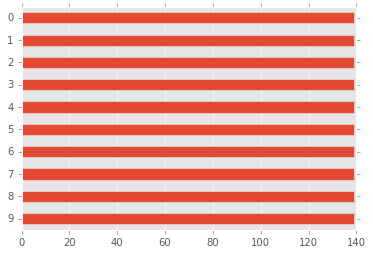

In [5]:
data_df.index.value_counts().plot(kind='barh')

In [7]:
from sklearn.feature_selection import f_classif

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016843883C88>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000168438D5F60>], dtype=object)

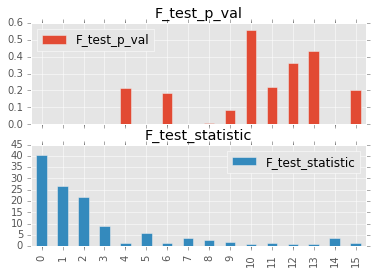

In [8]:
t_stats, p_vals = f_classif(data_df, data_df.index)
feature_importances = pd.DataFrame({'F_test_statistic': t_stats, 'F_test_p_val': p_vals})

feature_importances.plot(kind='bar', subplots=True)

In [10]:
feature_importances[feature_importances['F_test_p_val'] < 0.05]                

,F_test_p_val,F_test_statistic
0,1.872208e-64,40.496685
1,5.946963e-43,26.767110
2,7.074440e-35,21.823466
3,4.524536e-13,8.863450
5,6.777722e-08,5.765740
7,1.609031e-04,3.648553
8,5.446876e-03,2.610393
14,1.727062e-04,3.628439


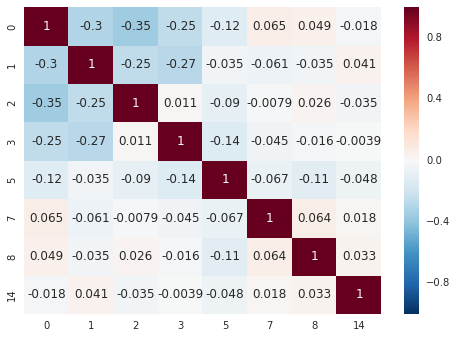

In [17]:
f_subset = feature_importances[feature_importances['F_test_p_val'] < 0.05]
relevant_features = data_df.loc[:, [str(col) for col in f_subset.index]]

rf_corrs = relevant_features.corr()

import seaborn as sns
sns.heatmap(rf_corrs, annot=True)

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

In [39]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(f_classif, k=8)
normalizer = StandardScaler()
estimator = SVC(C=100)

cv = StratifiedKFold(n_splits=5, shuffle=True)

pipeline = Pipeline([
    ('selector', selector),
    ('normalizer', normalizer),
    ('estimator', estimator),
])

scores = cross_val_score(pipeline, data_df, data_df.index, cv=cv, scoring='f1_macro')

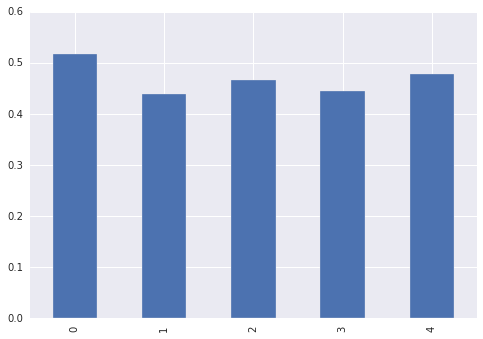

In [40]:
scores = pd.Series(scores)
scores.plot(kind='bar')